In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables

In [29]:
''' 

95 Percentile
BAC 1wk 7.16%, 1d 2.5%, 1hr 1%
CRM 1d 2.76%, 1hr 1%
IDEX 1d 10.8%, 1hr 4.15%
IYW 1d 1.5%, 1hr 0.697%
JEF 1d 2.5%, 1hr 1.1%
NVAX 1d 6.46%, 1hr 3.15%
QDEL 1d 3.53%, 1hr 
TSLA 1d 4.3%, 1hr 1.66%
VBIV 1d 7.99%, 1hr 4.05%
VGT 1d 1.41% 1hr 0.686%
VHT 1d 1.24%, 1hr 0.59%

'''

interval = '60m' # 60m or 1d or 1wk
history = '2y' # 2y for 60m, 10y for 1d, 25y or max for 1wk
perc_inc = 0.01 # see percentages above
symbol = 'BAC'
perc_train = 0.25
load_new = 1 # 0 for reuse, 1 for load new from server
current = 0 # 0 for 2nd to last data point (once markets open), 1 for last data point (when market is closed)
loc = -1 # row for previous nth interval, -2 (once market open)

In [30]:
if interval == '1d' or interval == '1wk':
    index_col = 'Date'
else:
    index_col = 'Datetime'

In [31]:
stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
stock_df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-08-29 09:30:00-04:00,31.260000,31.264999,31.070000,31.190001,31.190001,8470863
2018-08-29 10:30:00-04:00,31.190001,31.309999,31.180000,31.285000,31.285000,4713292
2018-08-29 11:30:00-04:00,31.285000,31.309000,31.230000,31.240000,31.240000,10547127
2018-08-29 12:30:00-04:00,31.230000,31.240000,31.110001,31.155001,31.155001,5160899
2018-08-29 13:30:00-04:00,31.160000,31.160000,31.084999,31.135000,31.135000,3436194


In [32]:
def direction(interval = interval
              , history = history
              , perc_inc = perc_inc
              , symbol = symbol
              , perc_train = perc_train
              , load_new = load_new 
              , current = current
              , loc = loc
             ):
    
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )
    
    # Load New From Server
    if load_new == 1:
        stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
        
        # Create Percent Change
        stock_df['percent change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
        
        # Create High Low Difference
        stock_df['hl percent change'] = np.where(stock_df['percent change'] > 0
                                , (stock_df.High - stock_df.Low)/stock_df.Low
                                , (stock_df.Low - stock_df.High)/stock_df.High
                               )

        #create decision column
        stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc

                                        , 1  # 1 if up % or greater

                                        , 0  # 0 if not up % or greater

                                       )
        # Create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
        
        # Drop NaN
        stock_df.dropna(axis=0
                        , inplace = True
                       )

        # Save DF to CSV
        stock_df.to_csv('stock_df.csv')
        
    else:
        if interval == '1d' or interval == '1wk':
            index_col = 'Date'
        else:
            index_col = 'Datetime'
   
        stock_df = pd.read_csv('stock_df.csv', index_col=index_col)
    
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
 
    # balance the data
    ones = stock_df_one_off.decision.value_counts()[1]
    stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)
    
    # check for NaN's
    stock_df_bal.dropna(axis=0, inplace=True)
    
    # Train Test Split
    X = stock_df_bal.drop(columns=['decision']) # get columns other than decision
    y = stock_df_bal['decision'] # get decision column
    
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , y
                                                        , test_size=0.20
                                                        , random_state = 42
                                                       )

    #random forest classifier rfc
    if symbol == 'BAC' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 2
                                     , max_features = 1
                                     , min_samples_leaf = 5
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'BAC' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 4
                                     , max_features = 4
                                     , min_samples_leaf = 2
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'CRM' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'CRM' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 2
                                     , min_samples_leaf = 1
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'IDEX' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 6
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'IDEX' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 2
                                     , min_samples_split = 4
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'IYW' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 4
                                     , min_samples_leaf = 4
                                     , min_samples_split = 2
                                     , n_estimators = 105 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'IYW' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 6
                                     , max_features = 2
                                     , min_samples_leaf = 2
                                     , min_samples_split = 6
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

        
    elif symbol == 'JEF' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 3
                                     , min_samples_split = 5
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'JEF' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 2
                                     , max_features = 4
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'NVAX' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 1
                                     , max_features = 3
                                     , min_samples_leaf = 3
                                     , min_samples_split = 4
                                     , n_estimators = 45 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'NVAX' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 4
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'QDEL' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 2
                                     , max_features = 4
                                     , min_samples_leaf = 2
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'QDEL' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 45 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'TSLA' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 1
                                     , max_features = 3
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'TSLA' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 6
                                     , max_features = 1
                                     , min_samples_leaf = 4
                                     , min_samples_split = 3
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    elif symbol == 'VBIV' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 3
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'VBIV' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 6
                                     , max_features = 4
                                     , min_samples_leaf = 5
                                     , min_samples_split = 5
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'VGT' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 3
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 2
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )

    elif symbol == 'VGT' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 2
                                     , min_samples_leaf = 1
                                     , min_samples_split = 3
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
        
    elif symbol == 'VHT' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 5
                                     , max_features = 6
                                     , min_samples_leaf = 3
                                     , min_samples_split = 4
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    
    else: # 1hr VHT
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 4
                                     , max_features = 5
                                     , min_samples_leaf = 5
                                     , min_samples_split = 6
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )


    
    
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_probs = rfc.predict_proba(X_test)[:, 1]
    
    # ROC Value
    roc_value = roc_auc_score(y_test
                              , y_probs
                             )
    
    # AUC Score
    rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
    auc_value = round(auc(rf_recall, rf_prec), 3)
    
    # Feature Importances
    # feature_df = pd.DataFrame({'feature': X_train.columns
    #                            , 'importances': rfc.feature_importances_
    #                           }
    #                          ).sort_values('importances', ascending=False)
    
    # Current = 1 uses most up to date data, = 0 for one pervious current data
    if current == 1:
        loc = -1
    else:
        loc = loc
        
    # Prediction
    last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'percent change', 'hl percent change']].iloc[loc]
    if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
        result = f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.'
    else:
        result = f'Sell or hold {symbol} on the {interval} interval.'
        
    return ones, roc_value, auc_value, result

In [33]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = perc_inc
                                   , symbol = symbol
                                   , perc_train = perc_train
                                   , load_new = load_new 
                                   , current = current
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 182
ROC Score: 0.72
AUC Score: 0.77
Sell or hold BAC on the 60m interval.


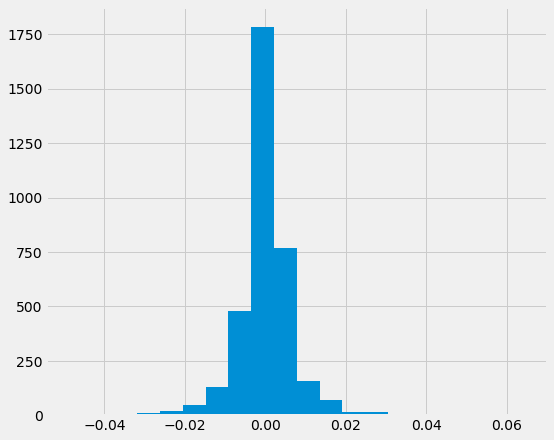

In [34]:
stock_df = pd.read_csv('stock_df.csv', index_col=index_col) # 'Date' for 1d, 'Datetime' for 60m
stock_df['percent change'].hist(bins=20)

In [35]:
stock_df['percent change'].quantile([0.84])

0.84    0.004384
Name: percent change, dtype: float64

In [36]:
perc = [x*0.01 for x in range(5,105, 5)]
perc

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]

In [37]:
roc_lst = []
auc_lst = []
results_lst = []
perc = [x*0.01 for x in range(5,105, 5)]

for x in perc:
    ones, roc, auc, result = direction(interval = interval
                                       , history = history
                                       , perc_inc = perc_inc
                                       , symbol = symbol
                                       , perc_train = x
                                       , load_new = load_new
                                       , current = current
                                       , loc = loc
                                      )
    roc_lst.append(roc)
    auc_lst.append(auc)
    results_lst.append(result)

results_df = pd.DataFrame({'Percent': perc
                           , 'ROC': roc_lst
                           , 'AUC': auc_lst
                           , 'Result': results_lst
                          }
                         )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [38]:
results_df

,Percent,ROC,AUC,Result
0,0.05,0.793919,0.790,Buy BAC on the 60m interval for 1.0% increase.
1,0.10,0.861111,0.870,Sell or hold BAC on the 60m interval.
2,0.15,0.736111,0.687,Sell or hold BAC on the 60m interval.
3,0.20,0.746997,0.685,Sell or hold BAC on the 60m interval.
4,0.25,0.834459,0.873,Buy BAC on the 60m interval for 1.0% increase.
5,0.30,0.694444,0.677,Sell or hold BAC on the 60m interval.
6,0.35,0.852102,0.813,Sell or hold BAC on the 60m interval.
7,0.40,0.650526,0.628,Sell or hold BAC on the 60m interval.
8,0.45,0.830706,0.825,Sell or hold BAC on the 60m interval.
9,0.50,0.792042,0.833,Sell or hold BAC on the 60m interval.


In [39]:
results_df.Result.value_counts()

Sell or hold BAC on the 60m interval.             17
Buy BAC on the 60m interval for 1.0% increase.     3
Name: Result, dtype: int64

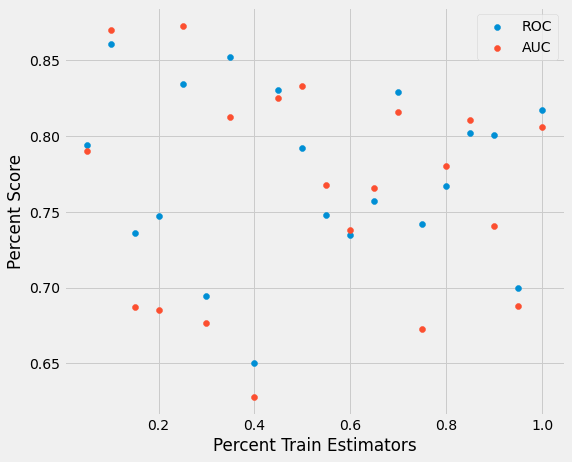

In [40]:
plt.scatter(results_df.Percent
            , results_df.ROC
            , label = 'ROC'
           )
plt.scatter(results_df.Percent
            , results_df.AUC
            , label = 'AUC'
           )
plt.xlabel('Percent Train Estimators')
plt.ylabel('Percent Score')
plt.legend();


In [41]:
results_df.loc[results_df.ROC == results_df.ROC.max()]

,Percent,ROC,AUC,Result
1,0.1,0.861111,0.87,Sell or hold BAC on the 60m interval.


In [42]:
best_perc = results_df.loc[results_df.ROC == results_df.ROC.max()].Percent.iloc[0]
best_perc

0.1

In [43]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = 0.02
                                   , symbol = symbol
                                   , perc_train = best_perc
                                   , current = 1
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 37
ROC Score: 0.81
AUC Score: 0.76
Sell or hold BAC on the 60m interval.


In [44]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,percent change,hl percent change,decision
Datetime,,,,,,,,,
2020-08-28 11:30:00-04:00,26.125000,26.260000,26.105000,26.230101,26.230101,3711001,0.004023,0.005938,0
2020-08-28 12:30:00-04:00,26.237200,26.280001,26.170000,26.195000,26.195000,4672483,-0.001608,-0.004186,0
2020-08-28 13:30:00-04:00,26.200001,26.260000,26.160000,26.240999,26.240999,3502026,0.001565,0.003823,0
2020-08-28 14:30:00-04:00,26.240000,26.320000,26.209999,26.275000,26.275000,4460370,0.001334,0.004197,0
2020-08-28 15:30:00-04:00,26.275000,26.320000,26.230000,26.295000,26.295000,4934608,0.000761,0.003431,0


### Thirty-One Calls

In [45]:
roc_scores = []
auc_scores = []
decisions = []
for _ in range(31):
    _, roc, auc, result = direction(interval = interval
                                    , history = history
                                    , perc_inc = perc_inc
                                    , symbol = symbol
                                    , perc_train = best_perc
                                    , load_new = load_new
                                    , current = current
                                    , loc = loc
                                   )
    roc_scores.append(roc)
    auc_scores.append(auc)
    decisions.append(result)

twenty_one_df = pd.DataFrame({'roc': roc_scores
                              , 'auc': auc_scores
                              , 'decision': decisions
                             })
print(f'Location: {loc}')
print(stock_df.iloc[loc])
twenty_one_df.decision.value_counts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Sell or hold BAC on the 60m interval.             30
Buy BAC on the 60m interval for 1.0% increase.     1
Name: decision, dtype: int64

### Get pervious n predictions

In [48]:
# ''' 

# 95 Percentile
# BAC 1wk 7.16%, 1d 2.5%, 1hr 1%
# CRM 1d 2.76%, 1hr 1%
# IDEX 1d 10.8%, 1hr 4.15%
# IYW 1d 1.5%, 1hr 0.697%
# JEF 1d 2.5%, 1hr 1.1%
# NVAX 1d 6.46%, 1hr 3.15%
# QDEL 1d 3.53%, 1hr 
# TSLA 1d 4.3%, 1hr 1.66%
# VBIV 1d 7.99%, 1hr 4.05%
# VGT 1d 1.41% 1hr 0.686%
# VHT 1d 1.24%, 1hr 0.59%

# '''

interval = '60m' # 60m or 1d
history = '2y' # 2y for 60m, max for 1d
perc_inc = 0.006 # 0.008 for 60m, 0.02 for 1d (IYW)
symbol = 'BAC'
perc_train = 0.25
load_new = 0 # 0 for reuse, 1 for load new from server
current = 0 # 0 for 2nd to last data point (once markets open), 1 for last data point (when market is closed)
# loc = -169 # row for previous nth interval, -2 (once market open)
n = 211 # num of pervious calls 

def calls(n):
    lst = []
    for i in range(-n,0):
        roc_scores = []
        auc_scores = []
        decisions = []
        for _ in range(25):
            _, roc, auc, result = direction(interval = interval
                                            , history = history
                                            , perc_inc = perc_inc
                                            , symbol = symbol
                                            , perc_train = best_perc
                                            , load_new = load_new
                                            , current = current
                                            , loc = -i
                                           )
            roc_scores.append(roc)
            auc_scores.append(auc)
            decisions.append(result)

        twenty_one_df = pd.DataFrame({'roc': roc_scores
                                      , 'auc': auc_scores
                                      , 'decision': decisions
                                     })
        
        lst.append(twenty_one_df.decision.value_counts().index[0])
    return [x for x in range(-n,0)], lst

nth, pred = calls(n)
dict_calls = {'prev_nth': nth
              , 'prediction': pred
             }
df_calls = pd.DataFrame(dict_calls)
df_calls

,prev_nth,prediction
0,-211,Sell or hold BAC on the 60m interval.
1,-210,Sell or hold BAC on the 60m interval.
2,-209,Buy BAC on the 60m interval for 0.6% increase.
3,-208,Sell or hold BAC on the 60m interval.
4,-207,Sell or hold BAC on the 60m interval.
5,-206,Sell or hold BAC on the 60m interval.
6,-205,Sell or hold BAC on the 60m interval.
7,-204,Sell or hold BAC on the 60m interval.
8,-203,Sell or hold BAC on the 60m interval.
9,-202,Sell or hold BAC on the 60m interval.
